## packages

In [1]:
%load_ext autoreload
    
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# from kerr_cat.notebooks.qnl_trajectories import *
from matplotlib import pyplot as plt
from matplotlib import cm
import pickle
import time 
import matplotlib as mpl
# import plotting_settings
# from kerr_cat.notebooks.qnl_trajectories.analysis.utils import greek, find_nearest
import qutip as qt
from qutip import *
# from kerr_cat.notebooks.qnl_trajectories.analysis.gate_error_diagnosis.plotting import plot_operator
from scipy import constants
import numpy as np
from scipy import signal
import scipy as sp
import pickle

In [529]:
qt.__version__

'4.7.5'

In [473]:
def wigner(state, a_lim = None, ax = None):
    position = np.sqrt(alpha_sq+det0/K/2)*np.sqrt(2)
    re_a = np.linspace(-position - 2, position + 2 , 101)
    im_a = np.linspace(-5, 5, 101)
    if a_lim is not None:
        re_a = np.linspace(-a_lim, a_lim, 101)
        im_a = np.linspace(-a_lim, a_lim, 101)
        
    W_psi0 = qt.wigner(state, re_a, im_a)
    if ax is None:
        for W in [W_psi0]:
            # plt.figure(figsize=(3, 2))
            plt.figure(figsize=(10,10), dpi=50)
            plt.pcolormesh(re_a, im_a, W, cmap=plt.cm.RdBu_r, label = 's')
            # clims = (-0.3, 0.3)
            # plt.clim(clims)
            plt.gca().set_aspect('equal')
            plt.axis('off')
            plt.axhline(0)
            plt.axvline(np.sqrt(alpha_sq+det0/K/2)*np.sqrt(2))
            plt.axvline(-np.sqrt(alpha_sq+det0/K/2)*np.sqrt(2))
    else:
        for W in [W_psi0]:
            # plt.figure(figsize=(3, 2))
            ax.pcolormesh(re_a, im_a, W, cmap=plt.cm.RdBu_r, label = 's')
            # clims = (-0.3, 0.3)
            # plt.clim(clims)
            ax.set_aspect('equal')
            ax.axis('off')
            ax.axhline(0)
            ax.axvline(np.sqrt(alpha_sq+det0/K/2)*np.sqrt(2))
            ax.axvline(-np.sqrt(alpha_sq+det0/K/2)*np.sqrt(2))

## Single cat parameters

In [6]:
# n_levels = 30 # size of the Hilbert space
Ks =  2*np.pi*1e6 * np.array([1.1,1.1]) # Kerr in Hz
alpha_sqs = [4,4] # Cat size 
det0s = np.array([0,0])*Ks

## Single cat Hamiltonians

In [7]:
def Hcat_det(K, alpha_sq, det, n_levels):
    a = qt.destroy(n_levels)
    return det*a.dag()*a- K * a.dag() * a.dag() * a * a + K * (alpha_sq * a.dag() *a.dag() + np.conj(alpha_sq) *a * a)

In [8]:
def Hcat_drive(t, epsilon, n_levels, detuning):
    a = qt.destroy(n_levels)
    return epsilon.conj() * a * np.exp(-1j*detuning*t) + epsilon * a.dag() * np.exp(1j*detuning*t)

# Two cat effective Hamiltonian

In [15]:
def H_two_cat_det(Ks, alpha_sqs, dets, n_levels):
    a1 = qt.tensor(qt.destroy(n_levels), qt.identity(n_levels))
    a2 = qt.tensor(qt.identity(n_levels), qt.destroy(n_levels))
    # print(Ks, alpha_sqs, dets)
    return dets[0]*a1.dag()*a1- Ks[0] * a1.dag() * a1.dag() * a1 * a1 + Ks[0] * (alpha_sqs[0] * a1.dag() *a1.dag() + np.conj(alpha_sqs[0]) *a1 * a1)\
          +dets[1]*a2.dag()*a2- Ks[1] * a2.dag() * a2.dag() * a2 * a2 + Ks[1] * (alpha_sqs[1] * a2.dag() *a2.dag() + np.conj(alpha_sqs[1]) *a2 * a2)
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, fixed
from matplotlib import pyplot as plt
import numpy as np
@interact(
    n_levels = widgets.IntSlider(5, min=5, max=100, step=1, readout_format='0.3f')
)

def plot(n_levels):
    a = qt.destroy(n_levels)
    n = a.dag()*a
    p = qt.Qobj(np.diag((-1)**np.diag(n.full())))

    gnd0 = qt.basis(n_levels,0)
    gnd1 = qt.basis(n_levels,1)
    
    eneg, ss_cat_evecs = qt.simdiag([Hcat_det(Ks[0], alpha_sqs[0], det0s[0], n_levels), p], evals = True)
    print(eneg[1][-1:-5:-1])
    psi0 = ss_cat_evecs[-1] if eneg[1][-1] > 0 else ss_cat_evecs[-2] # Start in one of the cat states., define +X as the even states
    psi1 = ss_cat_evecs[-1] if eneg[1][-1] < 0 else ss_cat_evecs[-2] # Start in one of the cat states., define -X as the even states
    
    overlap00 = psi0.overlap(gnd0)
    overlap11 = psi1.overlap(gnd1)
    
    psi0 = psi0 * np.exp(1j*np.angle(overlap00))
    psi1 = psi1 * np.exp(1j*np.angle(overlap11) + 1j*np.angle(alpha_sq)/2)
    
    psi_alpha=1/np.sqrt(2)*(psi0+psi1)
    psi_malpha=1/np.sqrt(2)*(psi0-psi1)
    
    psi_y=1/np.sqrt(2)*(psi0-1j*psi1)
    psi_my=1/np.sqrt(2)*(psi0+1j*psi1)
    
    basis_states = [psi0, psi1, psi_alpha, psi_malpha, psi_y, psi_my]
    basis_names = ['+X', '-X', '+Z', '-Z', '+Y', '-Y']

    psi00 = qt.tensor(psi0, psi0)
    psi01 = qt.tensor(psi0, psi1)
    psi10 = qt.tensor(psi1, psi0)
    psi11 = qt.tensor(psi1, psi1)

    p1 = qt.tensor(p,qt.identity(n_levels))
    p2 = qt.tensor(qt.identity(n_levels), p)
    
    eneg2, ss_cat_evecs2 = qt.simdiag([p1, p2, H_two_cat_det(Ks, alpha_sqs, det0s, n_levels)], evals = True, safe_mode = True)
    indices = np.argsort(eneg2[2])
    ss_cat_evecs2 = [ss_cat_evecs2[index] for index in indices]
    print(np.array(eneg2[0])[indices[-1:-5:-1]],np.array(eneg2[1])[indices[-1:-5:-1]])
    for i in range(1,5):
        overlap = [abs(ss_cat_evecs2[-i].overlap(psi00))**2,abs(ss_cat_evecs2[-i].overlap(psi01))**2,abs(ss_cat_evecs2[-i].overlap(psi10))**2,abs(ss_cat_evecs2[-i].overlap(psi11))**2]
        index = np.argmax(overlap)
        if index == 0:
            psi00_real = ss_cat_evecs2[-i]
        if index == 1:
            psi01_real = ss_cat_evecs2[-i]
        if index == 2:
            psi10_real = ss_cat_evecs2[-i]
        if index == 3:
            psi11_real = ss_cat_evecs2[-i]
    re_a = np.linspace(-8, 8, 101)
    im_a = np.linspace(-5, 5, 101)
    W_psi0 = qt.wigner(psi00_real.ptrace(0), re_a, im_a)
    W_psi1 = qt.wigner(psi00_real.ptrace(1), re_a, im_a)
    W_psi2 = qt.wigner(psi01_real.ptrace(0), re_a, im_a)
    W_psi3 = qt.wigner(psi01_real.ptrace(1), re_a, im_a)
    W_psi4 = qt.wigner(psi10_real.ptrace(0), re_a, im_a)
    W_psi5 = qt.wigner(psi10_real.ptrace(1), re_a, im_a)
    W_psi6 = qt.wigner(psi11_real.ptrace(0), re_a, im_a)
    W_psi7 = qt.wigner(psi11_real.ptrace(1), re_a, im_a)
    
    fig, ax = plt.subplots(2,4)
    count = 0
    for W in [W_psi0,W_psi1,W_psi2,W_psi3,W_psi4,W_psi5, W_psi6, W_psi7]:
        ax[count%2, count//2].pcolormesh(re_a, im_a, W, cmap=plt.cm.RdBu_r, label = 's',vmin = -0.3, vmax = 0.3)
        ax[count%2, count//2].set_aspect('equal')
        ax[count%2, count//2].axis('off')
        ax[count%2, count//2].set_title(count)
        count += 1
    print(n_levels)

interactive(children=(IntSlider(value=5, description='n_levels', min=5, readout_format='0.3f'), Output()), _do…

In [37]:
# Check the optimal n_levels number
def optimal_n_levels(plot = True):
    K = np.max(Ks)
    alpha_sq = np.max(alpha_sqs)
    det0 = np.max(det0s)
    overlap = []
    flag = True
    for i, n_levels in enumerate(np.arange(5,101)):
        a = qt.destroy(n_levels)
        n = a.dag()*a
        p = qt.Qobj(np.diag((-1)**np.diag(n.full())))
        try:
            _, ss_cat_evecs = qt.simdiag([Hcat_det(K, alpha_sq, det0, n_levels), p], evals = True)
        except TypeError:
            overlap.append(np.nan)
            continue
        psi0 = ss_cat_evecs[-1] # Start in one of the cat states.
        psi1 = ss_cat_evecs[-2]
        psi_alpha=1/np.sqrt(2)*(ss_cat_evecs[-1]+ss_cat_evecs[-2])
        alpha = np.real(qt.coherent_dm(n_levels, np.sqrt(alpha_sq+det0/2/K)).overlap(psi_alpha))
        malpha = np.real(qt.coherent_dm(n_levels, -np.sqrt(alpha_sq+det0/2/K)).overlap(psi_alpha))
        overlap_val = alpha if alpha > malpha else malpha
        overlap.append(overlap_val)
        if i > 5:
            if overlap[i] >= 0.9 and np.abs(overlap[i]-overlap[i-5])<=1e-5 and n_levels >= 10 and flag:
                try:
                        # print('hello')
                    a = qt.destroy(n_levels+5)
                    n = a.dag()*a
                    p = qt.Qobj(np.diag((-1)**np.diag(n.full())))
                    _, ss_cat_evecs = qt.simdiag([Hcat_det(K, alpha_sq, det0, n_levels + 5), p], evals = True)
                    n_levels_opt = n_levels+5
                    flag = False
                    if not plot:
                        break
                except TypeError:
                    continue
    if plot:
        plt.plot(np.arange(5,101), overlap)
        plt.ylim(0.9,1.1)
        plt.xlabel('n_levels')
        plt.ylabel('overlap with coherent state')
        plt.grid()
    return n_levels_opt

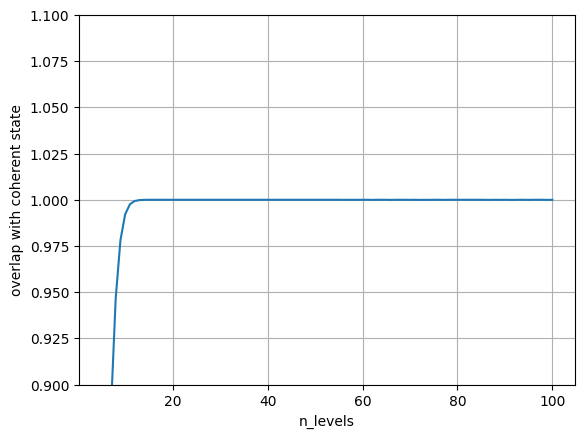

In [38]:
n_levels = optimal_n_levels(plot)

In [40]:
# define the two cat Hamiltonian and operators
a = qt.destroy(n_levels)
iden = qt.identity(n_levels)
a1 = qt.tensor(a, iden)
a2 = qt.tensor(iden, a)

def H_two_cat_det(Ks, alpha_sqs, dets, n_levels):
    # print(Ks, alpha_sqs, dets)
    return dets[0]*a1.dag()*a1- Ks[0] * a1.dag() * a1.dag() * a1 * a1 + Ks[0] * (alpha_sqs[0] * a1.dag() *a1.dag() + np.conj(alpha_sqs[0]) *a1 * a1)\
          +dets[1]*a2.dag()*a2- Ks[1] * a2.dag() * a2.dag() * a2 * a2 + Ks[1] * (alpha_sqs[1] * a2.dag() *a2.dag() + np.conj(alpha_sqs[1]) *a2 * a2)

In [41]:
def def_basis_states():
    gnd0 = qt.basis(n_levels,0)
    gnd1 = qt.basis(n_levels,1)
    
    a = qt.destroy(n_levels)
    n = a.dag()*a
    p = qt.Qobj(np.diag((-1)**np.diag(n.full())))

    global psi_alpha
    global psi_malpha
    global psi_y
    global psi_my
    global psi0
    global psi1   

    global cat00
    global cat01
    global cat10
    global cat11
    global psi00_real
    global psi01_real
    global psi10_real
    global psi11_real
    global psi00
    global psi01
    global psi10
    global psi11
    a = qt.destroy(n_levels)
    n = a.dag()*a
    p = qt.Qobj(np.diag((-1)**np.diag(n.full())))

    gnd0 = qt.basis(n_levels,0)
    gnd1 = qt.basis(n_levels,1)
    
    eneg, ss_cat_evecs = qt.simdiag([Hcat_det(K, alpha_sq, det0, n_levels), p], evals = True)
    psi0 = ss_cat_evecs[-1] if eneg[1][-1] > 0 else ss_cat_evecs[-2] # Start in one of the cat states., define +X as the even states
    psi1 = ss_cat_evecs[-1] if eneg[1][-1] < 0 else ss_cat_evecs[-2] # Start in one of the cat states., define -X as the even states
    
    overlap00 = psi0.overlap(gnd0)
    overlap11 = psi1.overlap(gnd1)
    
    psi0 = psi0 * np.exp(1j*np.angle(overlap00))
    psi1 = psi1 * np.exp(1j*np.angle(overlap11) + 1j*np.angle(alpha_sq)/2)
    
    psi_alpha=1/np.sqrt(2)*(psi0+psi1)
    psi_malpha=1/np.sqrt(2)*(psi0-psi1)
    
    psi_y=1/np.sqrt(2)*(psi0-1j*psi1)
    psi_my=1/np.sqrt(2)*(psi0+1j*psi1)
    
    basis_states = [psi0, psi1, psi_alpha, psi_malpha, psi_y, psi_my]
    basis_names = ['+X', '-X', '+Z', '-Z', '+Y', '-Y']

    psi00 = qt.tensor(psi0, psi0)
    psi01 = qt.tensor(psi0, psi1)
    psi10 = qt.tensor(psi1, psi0)
    psi11 = qt.tensor(psi1, psi1)

    p1 = qt.tensor(p,qt.identity(n_levels))
    p2 = qt.tensor(qt.identity(n_levels), p)
    eneg2, ss_cat_evecs2 = qt.simdiag([p1, p2, H_two_cat_det(Ks, alpha_sqs, det0s, n_levels)], evals = True, safe_mode = False)
    indices = np.argsort(eneg2[2])
    ss_cat_evecs2 = [ss_cat_evecs2[index] for index in indices]
    print(np.array(eneg2[0])[indices[-1:-5:-1]],np.array(eneg2[1])[indices[-1:-5:-1]])
    for i in range(1,5):
        overlap = [abs(ss_cat_evecs2[-i].overlap(psi00))**2,abs(ss_cat_evecs2[-i].overlap(psi01))**2,abs(ss_cat_evecs2[-i].overlap(psi10))**2,abs(ss_cat_evecs2[-i].overlap(psi11))**2]
        index = np.argmax(overlap)
        if index == 0:
            psi00_real = ss_cat_evecs2[-i]
        if index == 1:
            psi01_real = ss_cat_evecs2[-i]
        if index == 2:
            psi10_real = ss_cat_evecs2[-i]
        if index == 3:
            psi11_real = ss_cat_evecs2[-i]
    # psi0 uis the eigenstates, which is the cat state, cat00 is the bloch 00 state of the cat computational basis, which is |alpha> x |alpha>
    
    cat00 = (psi00_real+psi01_real+psi10_real+psi11_real)/2
    cat01 = (psi00_real-psi01_real+psi10_real-psi11_real)/2
    cat10 = (psi00_real+psi01_real-psi10_real-psi11_real)/2
    cat11 = (psi00_real-psi01_real-psi10_real+psi11_real)/2

In [42]:
def_basis_states()

[ 1.  1. -1. -1.] [ 1. -1.  1. -1.]


# some random lab frame Hamiltonian test

In [521]:
K = -2*np.pi*1.2e6
g4 = K/6
g3 = 2*np.pi*8*1e6
omega = 2*np.pi*5e9
n_levels = 25
a = qt.destroy(n_levels)
def Hcat_lab_static(n_levels, omega, g3, g4):
    a = qt.destroy(n_levels)
    return omega * a.dag()*a + g3 * (a.dag()+a)**3 + g4 * (a.dag()+a)**4

def Hcat_lab_static_only_kerr(n_levels, omega, g3, g4):
    a = qt.destroy(n_levels)
    return omega * a.dag()*a + g3 * (a.dag()+a)**3 + 6*g4*a.dag()*a.dag()*a*a

def Hcat_lab_static_only_RWA(n_levels, omega, g3, g4):
    a = qt.destroy(n_levels)
    return omega * a.dag()*a + 3 * g3 * (a.dag()*a.dag()*a + a.dag()*a*a) + 6*g4*a.dag()*a.dag()*a*a

In [522]:
def find_energy(enegs, evecs, state):
    return enegs[np.array([qt.ket2dm(state).overlap(evecs[i]) for i in range(len(evecs))]).argmax()]
def find_evecs(enegs, evecs, state):
    return evecs[np.array([qt.ket2dm(state).overlap(evecs[i]) for i in range(len(evecs))]).argmax()]

In [523]:
Hcat_static = Hcat_lab_static(n_levels, omega, g3, g4)
Hcat_static_only_kerr = Hcat_lab_static_only_kerr(n_levels, omega, g3, g4)

evals, evecs = Hcat_static.eigenstates()

In [524]:
omega01 = (find_energy(evals, evecs, qt.basis(n_levels, 1)) - find_energy(evals, evecs, qt.basis(n_levels, 0)))/2/np.pi/1e9
omega12 = (find_energy(evals, evecs, qt.basis(n_levels, 2)) - find_energy(evals, evecs, qt.basis(n_levels, 1)))/2/np.pi/1e9

In [525]:
def profile(t, profile_type, profile_params):
    if profile_type == 'raise':
        T_ramp = profile_params['T_ramp']
        result = np.sin(np.pi/2*t/T_ramp)**2 if t<=T_ramp else 1
    if profile_type == 'pulse':
        Tg = profile_params['Tg']
        T_ramp = profile_params['T_ramp']
        if t<T_ramp:
            result = np.sin(np.pi/2*t/T_ramp)**2
        elif t>Tg-T_ramp:
            result = np.sin(np.pi/2*(Tg-t)/T_ramp)**2
        else:
            result = 1
    return result

epsilon_d = np.abs(g4*6*4*2**2*omega/g3/3)

H_pump = (qt.destroy(n_levels)+qt.create(n_levels))
H_pump_profile = lambda t, args: epsilon_d * profile(t, 'raise', {'T_ramp': 10e-6}) * np.cos(2*omega*t)

In [526]:
H = [Hcat_static_only_kerr, [H_pump, H_pump_profile]]

In [527]:
ts = np.linspace(0, 10e-6, int(20e-6/0.1e-9))
init = qt.basis(n_levels, 0)
result = qt.mesolve(H, init, ts, options=qt.Options(store_states=True))

In [528]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, fixed
from matplotlib import pyplot as plt
import numpy as np
@interact(
    i = widgets.IntSlider(103200, min=0, max=len(ts)-1, step=300, readout_format='d')
)

def plot(i):
    a = qt.destroy(n_levels)
    fig, ax = plt.subplots(1,2, figsize = (12,6))
    angle = ts[i]*(omega)
    wigner((1j*a.dag()*a*angle).expm()*result.states[i], ax = ax[0])
    
    plt.plot(ts[0::1000], [profile(t, 'raise', {'T_ramp': 5e-6}) for t in ts[0::1000]])
    plt.title(ts[i])

    
    plt.axvline(ts[i])

interactive(children=(IntSlider(value=103200, description='i', max=199999, step=300), Output()), _dom_classes=…